In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle
import zipfile
import csv
import sys
import os
import gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as Model
import tensorflow.keras.layers as Layer

#from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
print(os.listdir("./"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['.bashrc', '.profile', '.vast_containerlabel', 'onstart.sh', 'onstart.log', '.ssh', '.cache', '.local', 'sample-submission.csv', 'train.csv', '.ipynb_checkpoints', '.ipython', 'test.zip', 'train.zip', 'Car-class.ipynb', '.keras', '.config']
Python       : 3.6.9 (default, Jan 26 2021, 15:33:00) 
Numpy        : 1.19.5
Tensorflow   : 2.5.0
Keras        : 2.5.0


# Setup

In [3]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

RANDOM_SEED = 42

EPOCHS = 10  # эпох на обучение
BATCH_SIZE = 8  # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR = 1e-3
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 224  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = './'
PATH = "./working/"  # рабочая директория

# EDA

In [4]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


Нет пропусков.

In [6]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Данные распределены равномерно

In [7]:
train_df['Category'].nunique()

10

В датасете представлено 10 марок машин

In [8]:
print('Распаковываем картинки')

for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile('./'+data_zip, "r") as z:
        z.extractall(PATH)

print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок


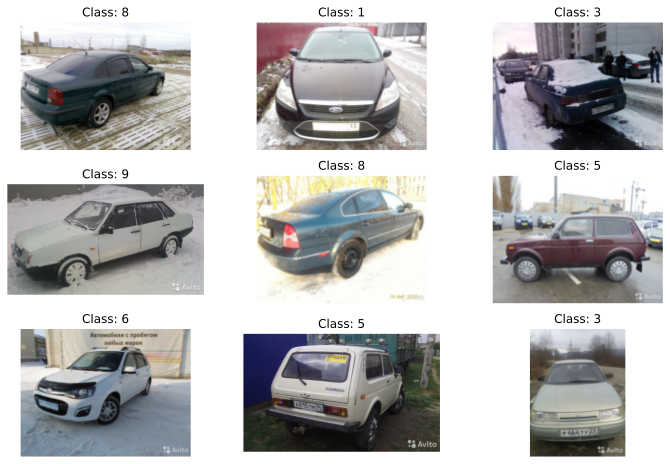

In [9]:
print('Пример картинок')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'/train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Картинки представлены разного размера

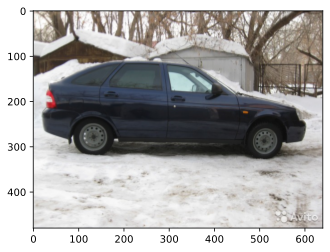

(640, 480)

In [10]:
# Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.
image = PIL.Image.open(PATH+f'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Аугментация данных

In [11]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [12]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625,
                       scale_limit=0.01,
                       interpolation=1,
                       border_mode=4,
                       rotate_limit=20,
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3,
                                   contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1,
                                   contrast_limit=0.1)],
            p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1,
               always_apply=False,
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


# Генерация данных

In [13]:
train_gen = ImageDataAugmentor(
    #                         rescale=1./255,
    augment=AUGMENTATIONS,
    seed=RANDOM_SEED,
    validation_split=VAL_SPLIT
)

train_datagen = train_gen.flow_from_directory(PATH+'/train',
                                              class_mode='categorical',
                                              batch_size=BATCH_SIZE,
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              shuffle=True,
                                              subset='training'
                                              )
test_datagen = train_gen.flow_from_directory(PATH+'/train',
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                             )

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


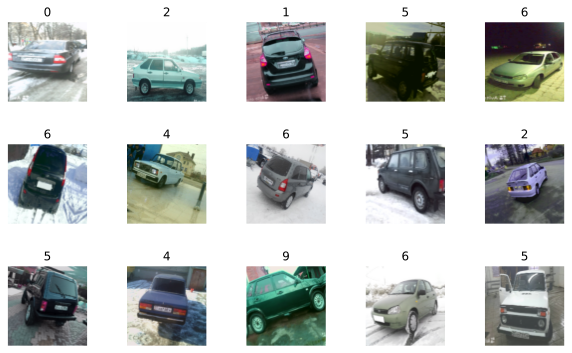

In [14]:
train_datagen.show_data(rows=3, cols=5)

# Модель

Загрузим предобученную модель

In [15]:
from tensorflow.keras.applications import EfficientNetB6

In [16]:
base_model = EfficientNetB6(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)

165240832/165234480 [==============================] - 1s 0us/step


In [17]:
base_model.summary()

Model: "efficientnetb6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

Total params: 40,960,143
Trainable params: 40,735,704
Non-trainable params: 224,439
__________________________________________________________________________________________________


In [18]:
# добавляем новую голову модели
model = Model.Sequential()
model.add(base_model)
model.add(Layer.GlobalAveragePooling2D())
model.add(Layer.Dense(256,
                      activation='relu',
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
model.add(Layer.BatchNormalization())
model.add(Layer.Dropout(0.25))
model.add(Layer.Dense(CLASS_NUM, activation='softmax'))

# ОБУЧЕНИЕ

## Для начала обучим только голову модели

In [19]:
# замораживаем все слои, кроме головы
base_model.trainable = False

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,817
Trainable params: 593,162
Non-trainable params: 40,960,655
______________________________________

In [21]:
# проверим статус обчаемых и необучаемых слоев
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f7680505f28> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f76c01ad898> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f763c067f98> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f763c067e10> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f763c06cb00> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f761d0dfd30> True


In [22]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
# Добавим ModelCheckpoint.
# Эта функция позволяет сохранять прогресс обучения модели,
# чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor=['val_accuracy'],
                             verbose=1,
                             mode='max')
# досрочное прекращение обучения
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=4,
                          restore_best_weights=True)
# управление learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [24]:
history = model.fit(
    train_datagen,
    steps_per_epoch=train_datagen.samples//train_datagen.batch_size,
    validation_data=test_datagen,
    validation_steps=test_datagen.samples//test_datagen.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/10
1654/1654 [==============================] - 148s 82ms/step - loss: 1.4431 - accuracy: 0.4946 - val_loss: 1.1021 - val_accuracy: 0.6100

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
1654/1654 [==============================] - 133s 80ms/step - loss: 1.1848 - accuracy: 0.5840 - val_loss: 0.9921 - val_accuracy: 0.6495

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1654/1654 [==============================] - 133s 81ms/step - loss: 1.1334 - accuracy: 0.5971 - val_loss: 0.9351 - val_accuracy: 0.6757

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1654/1654 [==============================] - 133s 80ms/step - loss: 1.0923 - accuracy: 0.6168 - val_loss: 0.9521 - val_accuracy: 0.6723

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1654/1654 [==============================] - 133s 80ms/step - loss: 1.0615 - accuracy: 0.6252 - val_loss: 0.8752 - val_accuracy: 0.7079

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1654/1654 [==============================] - 133s 80ms/step - loss: 1.0322 - accuracy: 0.6420 - val_loss: 0.8766 - val_accuracy: 0.7045

Epoch 00006: saving model to best_model.hdf5
Epoch 7/10
1654/1654 [=============

In [25]:
model.save('./working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [26]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 20s 69ms/step - loss: 0.7193 - accuracy: 0.7634
Accuracy: 76.34%


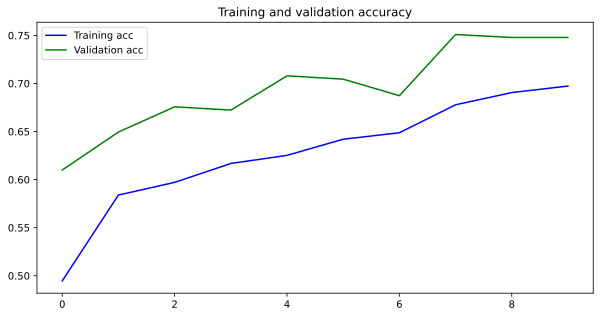

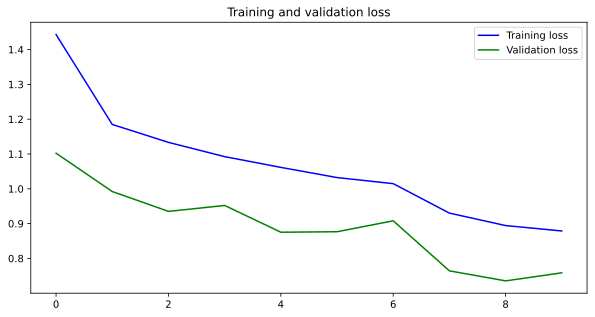

In [27]:
def plot_history(history):
    plt.figure(figsize=(10, 5))
    # plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    # plt.figure()
    plt.figure(figsize=(10, 5))
    # plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_history(history)

## Размораживаем для обучения половину прдобученных слоев


In [28]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [29]:
LR = 0.0001
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,817
Trainable params: 38,414,048
Non-trainable params: 3,139,769
____________________________________

In [31]:
history = model.fit(
    train_datagen,
    steps_per_epoch=train_datagen.samples//train_datagen.batch_size,
    validation_data=test_datagen,
    validation_steps=test_datagen.samples//test_datagen.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/10
1654/1654 [==============================] - 173s 96ms/step - loss: 0.9837 - accuracy: 0.6877 - val_loss: 0.3733 - val_accuracy: 0.8780

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1654/1654 [==============================] - 155s 94ms/step - loss: 0.4692 - accuracy: 0.8424 - val_loss: 0.3146 - val_accuracy: 0.9025

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1654/1654 [==============================] - 156s 94ms/step - loss: 0.3626 - accuracy: 0.8810 - val_loss: 0.2670 - val_accuracy: 0.9188

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1654/1654 [==============================] - 156s 94ms/step - loss: 0.2954 - accuracy: 0.9013 - val_loss: 0.2306 - val_accuracy: 0.9270

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1654/1654 [==============================] - 155s 94ms/step - loss: 0.2322 - accuracy: 0.9203 - val_loss: 0.2165 - val_accuracy: 0.9326

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1654/1654 [=============

In [32]:
model.save('./working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [33]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 20s 67ms/step - loss: 0.1848 - accuracy: 0.9480
Accuracy: 94.80%


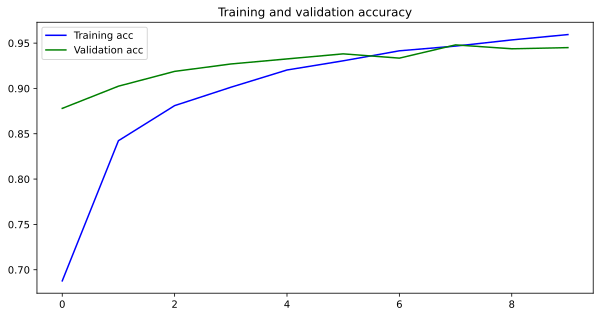

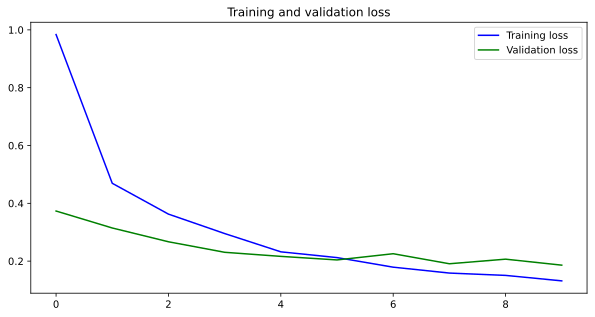

In [34]:
plot_history(history)

## Размораживаем для обучения три четверти предобученных слоев

In [35]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [36]:
LR = 0.00001

model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,817
Trainable params: 40,988,678
Non-trainable params: 565,139
______________________________________

In [38]:
history = model.fit(
    train_datagen,
    steps_per_epoch=train_datagen.samples//train_datagen.batch_size,
    validation_data=test_datagen,
    validation_steps=test_datagen.samples//test_datagen.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/10
1654/1654 [==============================] - 204s 114ms/step - loss: 0.1062 - accuracy: 0.9675 - val_loss: 0.1858 - val_accuracy: 0.9523

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1654/1654 [==============================] - 185s 112ms/step - loss: 0.0839 - accuracy: 0.9757 - val_loss: 0.1787 - val_accuracy: 0.9502

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1654/1654 [==============================] - 186s 112ms/step - loss: 0.0689 - accuracy: 0.9794 - val_loss: 0.1734 - val_accuracy: 0.9515

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1654/1654 [==============================] - 185s 112ms/step - loss: 0.0615 - accuracy: 0.9823 - val_loss: 0.1692 - val_accuracy: 0.9523

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1654/1654 [==============================] - 185s 112ms/step - loss: 0.0566 - accuracy: 0.9838 - val_loss: 0.1789 - val_accuracy: 0.9485

Epoch 00005: saving model to best_model.hdf5


In [39]:
model.save('./working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [40]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 20s 67ms/step - loss: 0.1774 - accuracy: 0.9558
Accuracy: 95.58%


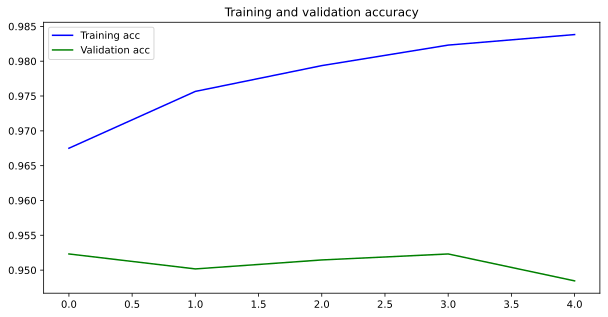

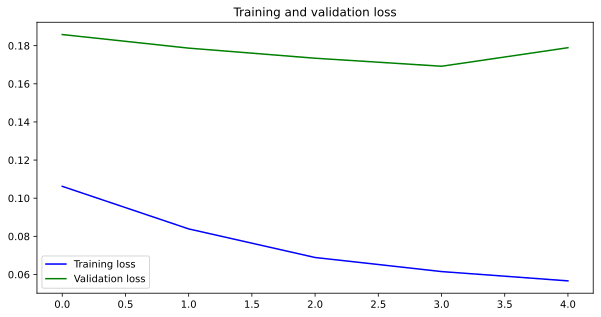

In [41]:
plot_history(history)

## Полностью размораживаем предобученную модель

In [42]:
base_model.trainable = True
LR = 0.000001
EPOCHS = 10

model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])

In [43]:
history = model.fit(
    train_datagen,
    steps_per_epoch=train_datagen.samples//train_datagen.batch_size,
    validation_data=test_datagen,
    validation_steps=test_datagen.samples//test_datagen.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/10
1654/1654 [==============================] - 326s 186ms/step - loss: 0.0537 - accuracy: 0.9856 - val_loss: 0.1773 - val_accuracy: 0.9532

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1654/1654 [==============================] - 305s 184ms/step - loss: 0.0564 - accuracy: 0.9832 - val_loss: 0.1615 - val_accuracy: 0.9575

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1654/1654 [==============================] - 305s 184ms/step - loss: 0.0537 - accuracy: 0.9853 - val_loss: 0.1795 - val_accuracy: 0.9519

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1654/1654 [==============================] - 304s 184ms/step - loss: 0.0506 - accuracy: 0.9859 - val_loss: 0.1520 - val_accuracy: 0.9648

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1654/1654 [==============================] - 304s 184ms/step - loss: 0.0530 - accuracy: 0.9850 - val_loss: 0.1718 - val_accuracy: 0.9553

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1654/1654 [========

In [44]:
model.save('./working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [45]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 20s 68ms/step - loss: 0.1734 - accuracy: 0.9536
Accuracy: 95.36%


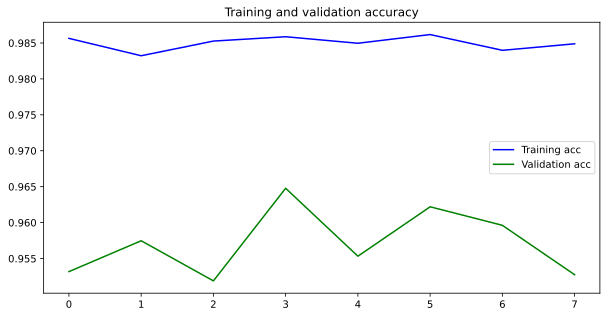

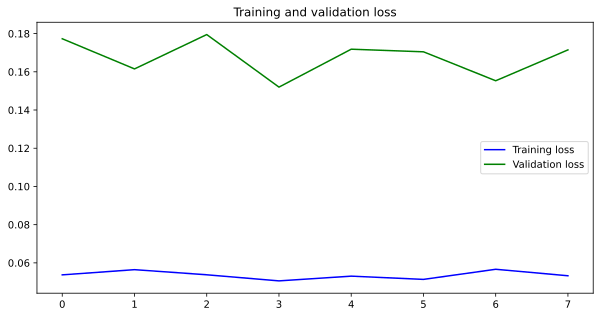

In [46]:
plot_history(history)

# Сделаем предикт после fine-tuning

In [47]:
# test_gen = ImageDataAugmentor(rescale=1./255)
test_gen = ImageDataAugmentor()
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                                  directory=PATH+'/test_upload/',
                                                  x_col="Id",
                                                  y_col=None,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  target_size=(
                                                      IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [48]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator,
                            steps=len(test_sub_generator),
                            verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 39s 44ms/step


In [49]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame({'Id': filenames_with_dir, 'Category': predictions},
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')

submission.to_csv('submission_after_ft.csv', index=False)

## УВЕЛИЧИМ РАЗМЕР КАРТИНОК

In [50]:
EPOCHS = 10
BATCH_SIZE = 2
LR = 1e-5

IMG_SIZE = 512
IMG_CHANNELS = 3
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [51]:
AUGMENTATIONS = A.Compose([
    #A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625,
                       scale_limit=0.01,
                       interpolation=1,
                       border_mode=4,
                       rotate_limit=20,
                       p=.75),
    A.HorizontalFlip(p=0.5),
    # A.HueSaturationValue(p=0.5)
])

In [52]:
train_gen = ImageDataAugmentor(
    augment=AUGMENTATIONS,
    seed=RANDOM_SEED,
    validation_split=VAL_SPLIT
)

train_datagen = train_gen.flow_from_directory(PATH+'/train',
                                              class_mode='categorical',
                                              batch_size=BATCH_SIZE,
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              shuffle=True,
                                              subset='training'
                                              )
test_datagen = train_gen.flow_from_directory(PATH+'/train',
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                             )

test_gen = ImageDataAugmentor()
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                                  directory=PATH+'/test_upload/',
                                                  x_col="Id",
                                                  y_col=None,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  target_size=(
                                                      IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [53]:
# пересоздадим модель под новые размеры входящих картинок

base_model = EfficientNetB6(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)

In [54]:
base_model.trainable = True

In [55]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR),
              metrics=["accuracy"])
model.load_weights('best_model.hdf5')

In [56]:
history = model.fit(
    train_datagen,
    steps_per_epoch=train_datagen.samples//train_datagen.batch_size,
    validation_data=test_datagen,
    validation_steps=test_datagen.samples//test_datagen.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/10
6616/6616 [==============================] - 1482s 221ms/step - loss: 1.0033 - accuracy: 0.7697 - val_loss: 0.1604 - val_accuracy: 0.9631

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
6616/6616 [==============================] - 1460s 221ms/step - loss: 0.6468 - accuracy: 0.8583 - val_loss: 0.1263 - val_accuracy: 0.9691

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
6616/6616 [==============================] - 1461s 221ms/step - loss: 0.5692 - accuracy: 0.8724 - val_loss: 0.1411 - val_accuracy: 0.9725

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
6616/6616 [==============================] - 1460s 221ms/step - loss: 0.5337 - accuracy: 0.8811 - val_loss: 0.1179 - val_accuracy: 0.9725

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
6616/6616 [==============================] - 1460s 221ms/step - loss: 0.5118 - accuracy: 0.8798 - val_loss: 0.1650 - val_accuracy: 0.9738

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
6616/6616 [===

In [57]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1165/1165 [==============================] - 49s 42ms/step - loss: 0.1577 - accuracy: 0.9721
Accuracy: 97.21%


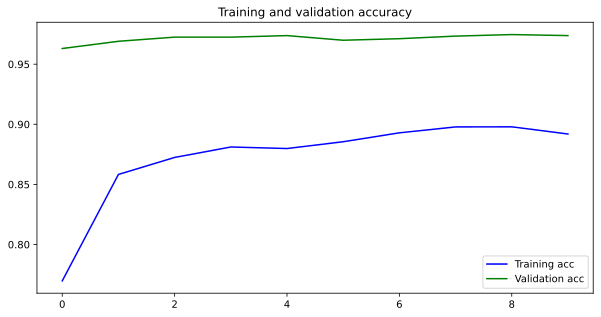

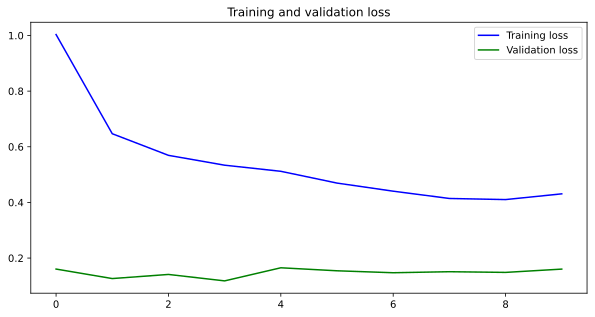

In [58]:
plot_history(history)

# Предикт на картинках большого размера

In [59]:
test_sub_generator.reset()
predictions = model.predict(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

3338/3338 [==============================] - 138s 40ms/step


In [60]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')

In [61]:
submission.to_csv('submission_IMG_SIZE.csv', index=False)

# Test Time Augmentation (TTA)

Аугментируем тестовые картинки.         
Сделаем несколько предсказаний на агументированном тестовом сете.         
В качестве финального предсказания берем среднее предсказание из сделанных.

In [62]:
model.load_weights('best_model.hdf5')

In [63]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625,
                       scale_limit=0.01,
                       interpolation=1,
                       border_mode=4,
                       rotate_limit=20,
                       p=.75),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3,
                                   contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1,
                                   contrast_limit=0.1)],
            p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1,
               always_apply=False,
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [64]:
test_gen = ImageDataAugmentor(
    augment=AUGMENTATIONS,
    seed=RANDOM_SEED,
    validation_split=VAL_SPLIT
)

test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                                  directory=PATH+'/test_upload',
                                                  x_col="Id",
                                                  y_col=None,
                                                  target_size=(
                                                      IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode=None,
                                                  shuffle=False)

Found 6675 validated image filenames.


In [ ]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, verbose=1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

2446/3338 [====================>.........] - ETA: 42s

In [ ]:
predictions = np.argmax(pred, axis=-1)  # multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame({'Id': filenames_with_dir, 'Category': predictions},
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/', '')

In [ ]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
submission.to_csv('submission_TTA.csv', index=False)

# Итоги             
                    
В проекте применены:     
- transfer learning и fine-tuning (обучение головы -> 50% разморозка весов предобученной модели -> 75% разморозка -> 100% разморозка)
- дополнительные функции callback в Keras        
- настройка LR    
- настройка параметров регуляризации полносвязного слоя нейронной сети
- применена аугментация keras
- применен способ заполнения пропусков c помощью ImageDataAugmentor с использованием библиотеки аугментации изображений albumentations (показаны лучше результаты, чем с аугментацией keras, поэтому оставлена albumentations)
- подобраны переменные (размер картинки, батч, количество эпох)
- добавлена Batch Normalization в архитектуре “головы” модели
- SOTA архитектура сетей - Xception, EfficientNetB6
- для EfficientNetB6 были применены веса imagenet и noisy student (лучшие результаты показали веса imagenet)
- добавлена TTA (Test Time Augmentation)
                  
Ввиду ограничений на пользование ресурсами GPU и времязатратности самого просчета модели, не удалось протестировать следующие техники настройки модели:

               